<a href="https://colab.research.google.com/github/James-Hagerman/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/W1D2_Assign_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [x] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [x] Engineer at least two new features. (See below for explanation & ideas.)
- [x] Fit a linear regression model with at least two features.
- [x] Get the model's coefficients and intercept.
- [x] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [x] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [x] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [33]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [34]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', parse_dates= ['created'], index_col= 'created')
assert df.shape == (49352, 33)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [35]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-nul

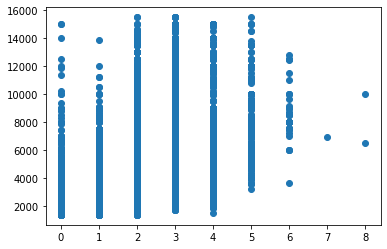

In [38]:
import matplotlib.pyplot as plt

plt.scatter(df['bedrooms'], df['price'])

##Feature Engineering

In [39]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

In [40]:
df['beds to bath'] = df['bedrooms'] / df['bathrooms']

In [41]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,beds to bath
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,2.0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,2.0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,4.0


In [48]:
df['beds to bath'] = df['beds to bath'].fillna(method = 'ffill')

In [49]:
df.isnull().sum()

bathrooms                  0
bedrooms                   0
description             1425
display_address          133
latitude                   0
longitude                  0
price                      0
street_address            10
interest_level             0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
dishwasher                 0
no_fee                     0
laundry_in_building        0
fitness_center             0
pre-war                    0
laundry_in_unit            0
roof_deck                  0
outdoor_space              0
dining_room                0
high_speed_internet        0
balcony                    0
swimming_pool              0
new_construction           0
terrace                    0
exclusive                  0
loft                       0
garden_patio               0
wheelchair_access          0
common_outdoor_space       0
total_rooms                0
beds to bath  

In [55]:
df.tail()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,beds to bath
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-02 05:41:05,1.0,2,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,2.0
2016-04-04 18:22:34,1.0,1,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,2.0,1.0
2016-04-16 02:13:40,1.0,1,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.0
2016-04-08 02:13:33,1.0,0,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0
2016-04-12 02:48:07,1.0,2,Look no further!!! This giant 2 bedroom apart...,Park Terrace East,40.8699,-73.9172,2200,30 Park Terrace East,low,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,2.0


##Train/Test Split

In [97]:
y = df['price']
X = df[['bedrooms',
        'bathrooms']]

print(y.shape)
print(X.shape)

(48817,)
(48817, 2)


In [98]:


# Training data split
X_train = X.loc['2016-04':'2016-05']
y_train = y.loc['2016-04':'2016-05']

# Validation Data Split
X_val = X.loc['2016-06':'2016-06']
y_val = y.loc['2016-06':'2016-06']

total_rooms     0
beds to bath    0
dtype: int64

## Model

In [99]:
from sklearn.linear_model import LinearRegression

In [100]:
# 1. Instantiate

model = LinearRegression()

# 2. Fit data to model

model.fit(X_train, y_train)

# 3. Make predictions

y_pred = model.predict(X_train)

In [101]:
model.coef_

array([ 389.3248959 , 2072.61011639])

In [102]:
model.intercept_

485.71869002322273

In [107]:
print(f'price = {model.intercept_} + {model.coef_[0]} x bedrooms + {model.coef_[1]} x bathrooms')

price = 485.71869002322273 + 389.32489590255824 x bedrooms + 2072.6101163851895 x bathrooms


###Metrics

In [104]:
from sklearn.metrics import mean_absolute_error

print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))

Training MAE: 818.5310213271714
validation MAE: 825.8987822403527


In [105]:
from sklearn.metrics import mean_squared_error

print('Training RMSE:', mean_squared_error(y_train, model.predict(X_train), squared = False))
print('Validation RMSE:', mean_squared_error(y_val, model.predict(X_val), squared = False))

Training RMSE: 1232.0225917223486
Validation RMSE: 1219.719357233823


In [106]:
from sklearn.metrics import r2_score

print('Training R2:', model.score(X_train, y_train))
print('Validation R2:', model.score(X_val, y_val))

Training R2: 0.5111543084316605
Validation R2: 0.5213303957090346
